## Скрипт для скачивания OSISAF

In [7]:
import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime

#ice_conc_nh_ease2-250_icdr-v3p0_202502071200.nc
def name_format(time: str, archive=True):
    #return f'ice_conc_nh_ease2-250_cdr-v3p1_{time}1200.nc'
    return f'ice_conc_nh_ease2-250_icdr-v3p0_{time}1200.nc'

def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_pack(folder_to_save, start_day, end_day):
    # Проверяем, что даты не в будущем
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Warning: End date {end_day} is in the future. Adjusting to today {today}")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    remote_dir = 'reprocessed/ice/conc-cont-reproc/v3p0'
    
    # Создаем одно подключение для всех файлов
    with ftplib.FTP('osisaf.met.no') as ftp:
        ftp.login()
        print("Connected to FTP server")
        
        # Создаем словарь для кэширования проверенных директорий
        valid_dirs = {}
        
        for date in dates:
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            file_name = name_format(date_str)
            
            # Проверяем существование файла локально
            local_path = Path(folder_to_save, file_name)
            if local_path.exists():
                print(f'Skipping existing file: {file_name}')
                continue
                
            # Формируем путь на сервере
            remote_path = f"{remote_dir}/{year}/{month}"
            
            # Проверяем, была ли директория уже проверена
            if remote_path in valid_dirs:
                if valid_dirs[remote_path] is False:
                    print(f"Skipping known invalid directory: {remote_path}")
                    continue
            else:
                # Проверяем существование директории
                try:
                    # Используем команду CWD для проверки существования директории
                    ftp.cwd(remote_path)
                    valid_dirs[remote_path] = True
                    print(f"Directory valid: {remote_path}")
                except ftplib.error_perm as e:
                    print(f"Directory not found: {remote_path} ({str(e)})")
                    valid_dirs[remote_path] = False
                    continue
            
            try:
                # Получаем список файлов в директории
                file_list = ftp.nlst()
                if file_name not in file_list:
                    print(f"File not found on server: {file_name}")
                    continue
                
                # Скачиваем файл
                if download(folder_to_save, file_name, ftp, silent=False):
                    print(f"Successfully downloaded: {file_name}")
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
                continue

# Пример вызова с актуальными датами
folder_to_save = 'osisaf_data'
download_pack(folder_to_save, '20250201', '20250205') 

Connected to FTP server
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502011200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502021200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502041200.nc
Skipping existing file: ice_conc_nh_ease2-250_icdr-v3p0_202502051200.nc


## Скрипт для скачивания MASIE 

In [8]:
## import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, date

def day_of_year(year, month, day):
    date_obj = date(year, month, day)
    return '%03d' % date_obj.timetuple().tm_yday
    
#masie_all_r00_v01_2025001_4km.nc
def masie_name_format(date_str: str):
    #return f'masie_4km_ice_r00_v01_{date_str}.nc'
    return f'masie_all_r00_v01_{date_str}_1km.nc'


def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_masie(folder_to_save, start_day, end_day):
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Adjusting end date to today ({today})")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    base_dir = '/DATASETS/NOAA/G02186/netcdf/1km'
    
    with ftplib.FTP('sidads.colorado.edu') as ftp:
        ftp.login()  # Анонимный вход
        print("Connected to NSIDC FTP server")
        
        valid_dirs_cache = {}
        
        for date in dates:
            
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            
            y, m, d = int(date_str[0:4]), int(date_str[4:6]), int(date_str[6:8]) 
            day_number = day_of_year(y, m, d)
            
            file_name = masie_name_format(f"{year}{day_number}")
            local_path = Path(folder_to_save, file_name)
            
            # Пропустить существующие файлы
            if local_path.exists():
                print(f'Skipping: {file_name}')
                continue
                
            # Формирование пути на сервере
            remote_dir = f"{base_dir}/{year}" #{day_number}" #/{month}"
            
            # Проверка директории в кэше
            if remote_dir in valid_dirs_cache:
                if not valid_dirs_cache[remote_dir]:
                    continue
            else:
                try:
                    ftp.cwd(remote_dir)
                    valid_dirs_cache[remote_dir] = True
                    print(f"Directory accessible: {remote_dir}")
                except ftplib.error_perm:
                    print(f"Directory not found: {remote_dir}")
                    valid_dirs_cache[remote_dir] = False
                    continue
            
            # Проверка наличия файла
            try:
                if file_name not in ftp.nlst():
                    print(f"File not available: {file_name}")
                    continue
                    
                download(folder_to_save, file_name, ftp)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

# Пример использования
folder_to_save = 'masie_data'
download_masie(folder_to_save, '20250201', '20250205')

Connected to NSIDC FTP server
Skipping: masie_all_r00_v01_2025032_1km.nc
Skipping: masie_all_r00_v01_2025033_1km.nc
Skipping: masie_all_r00_v01_2025034_1km.nc
Skipping: masie_all_r00_v01_2025035_1km.nc
Skipping: masie_all_r00_v01_2025036_1km.nc


## Plot files

Рисовать буду за 03.02.2025
Снимки:
1. osisaf
2. masie
3. Geotiff (оптика)
4. Гибридный снимок

tutor plot: https://medium.com/@Manjar-Alam/clipping-and-visualizing-netcdf-data-using-python-84dfbbbce0a5

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
import cmocean as cm
import rioxarray as rxr

In [2]:
ds_osisaf = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/osisaf_data/ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc')

In [3]:
ds_masie = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/masie_data/masie_all_r00_v01_2025034_1km.nc') #.squeeze()

In [4]:
ds_masie.x.shape

(24576,)

In [5]:
ds_masie.metadata_link

'https://doi.org/10.7265/N5GT5K3K'

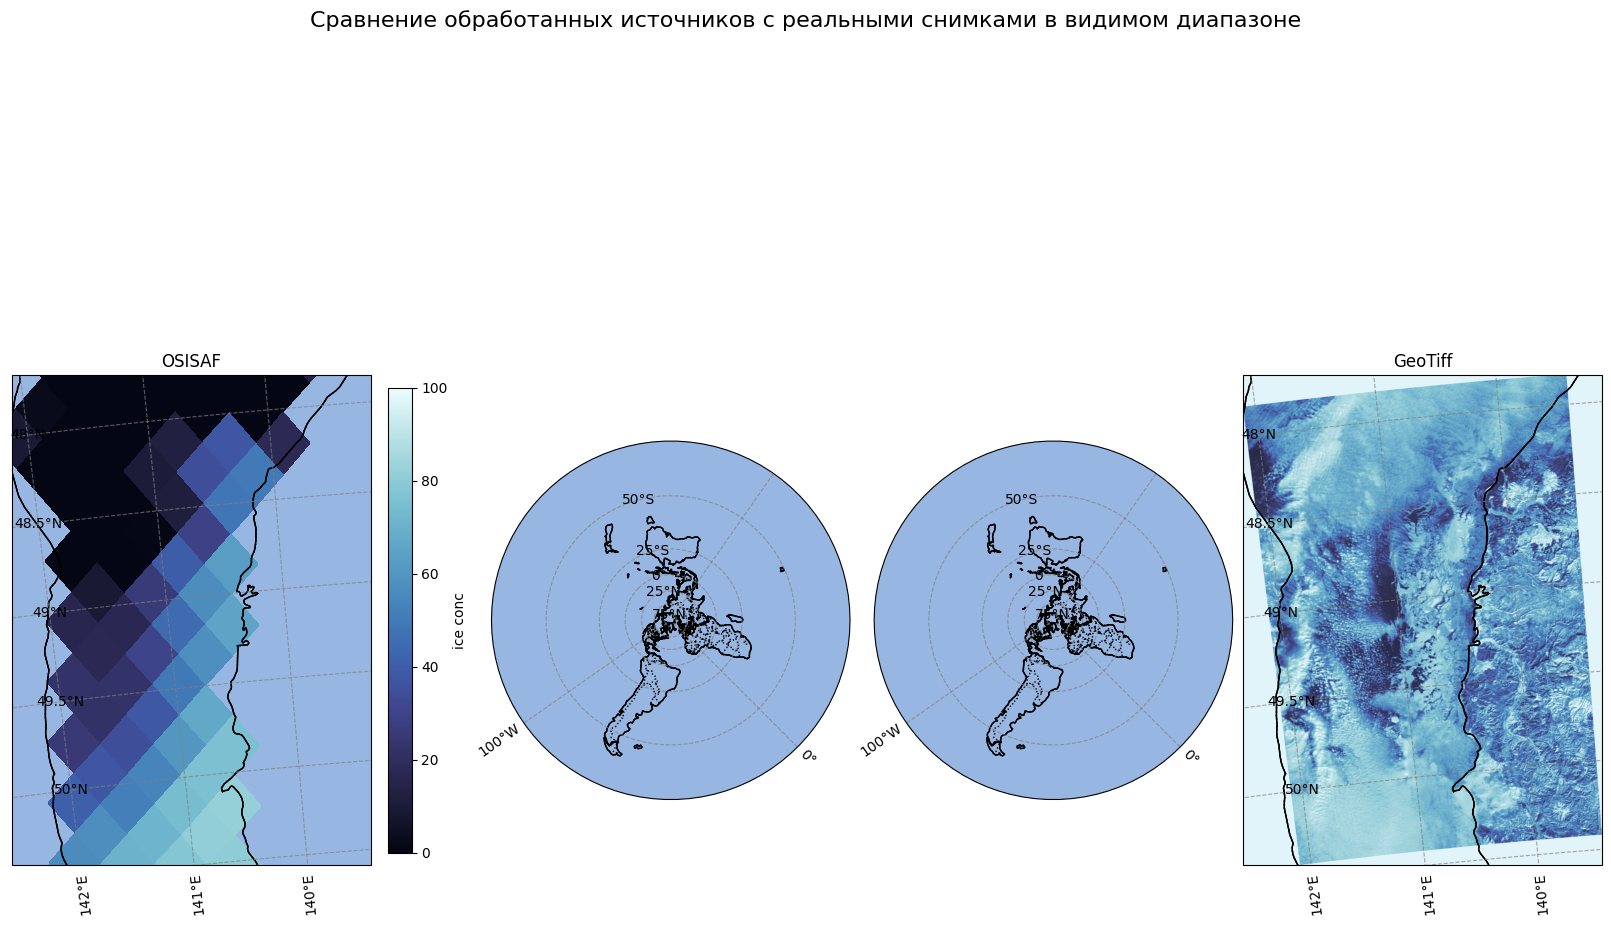

In [6]:
#fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.Stereographic(central_latitude=50, central_longitude=140)})



# Создаем фигуру с разными проекциями для последнего subplot
fig = plt.figure(figsize=(16, 12), layout="constrained")

# Первые три оси - Stereographic
#ax0 = fig.add_subplot(1, 4, 1, projecprint("X range:", ds_masie.x.min().item(), "to", ds_masie.x.max().item())
#ax1 = fig.add_subplot(1, 4, 2, projection=ccrs.Stereographic(central_latitude=50, central_longitude=140))
#ax2 = fig.add_subplot(1, 4, 3, projection=ccrs.Stereographic(central_latitude=50, central_longitude=140))

ax0 = fig.add_subplot(1, 4, 1, projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax1 = fig.add_subplot(1, 4, 2, projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax2 = fig.add_subplot(1, 4, 3, projection=ccrs.NorthPolarStereo(central_longitude=-45))


# Четвертая ось - NorthPolarStereo
ax3 = fig.add_subplot(1, 4, 4, projection=ccrs.NorthPolarStereo(central_longitude=-45))

axs = [ax0, ax1, ax2, ax3]

# Функция добавления координатной сетки
def add_gridlines(ax):
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = plt.MaxNLocator(nbins=4)
    gl.ylocator = plt.MaxNLocator(nbins=6)

# Добавляем побережья и сетку для всех осей
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':')
    add_gridlines(ax)

    

# setting tiff file
sar_file = '/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/snapshot-2025-02-03T00_00_00Z.tif'
sar_da = rxr.open_rasterio(sar_file).squeeze()

polar_crs = ccrs.NorthPolarStereo(central_longitude=-45)  # Полярная стереографическая проекция
sar_proj = sar_da.rio.reproject(polar_crs)

# ========================
# 1. Plot OSISAF
# ========================

mesh_osisaf = axs[0].pcolormesh(
    ds_osisaf['lon'].values, 
    ds_osisaf['lat'].values, 
    ds_osisaf['ice_conc'].values[0,:,:], 
    cmap=cm.cm.ice, 
    transform=ccrs.PlateCarree()
)

# Добавление цветовой шкалы
cbar = plt.colorbar(mesh_osisaf, ax=axs[0], orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('ice conc')

#axs[0].set_extent((135, 155, 40, 65), crs=ccrs.PlateCarree())
axs[0].set_extent([sar_proj.x.min().item(), sar_proj.x.max().item(), sar_proj.y.min().item(), sar_proj.y.max().item()], crs=ccrs.NorthPolarStereo(central_longitude=-45))
axs[0].set_title('OSISAF')

# ========================
# 2. Plot MASIE
# ========================

'''
mesh_masie = axs[1].pcolormesh(
    ds_masie['lon'].values, 
    ds_masie['lat'].values, 
    ds_masie['ice_conc'].values[0,:,:], 
    cmap=cm.cm.ice, 
    transform=ccrs.PlateCarree()
)

# Добавление цветовой шкалы
cbar = plt.colorbar(mesh_masie, ax=axs[1], orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('ice conc')

axs[1].set_extent((135, 155, 40, 65), crs=ccrs.PlateCarree())
axs[1].set_title('MASIE')
'''

# ========================
# 3. Plot satellite images
# ========================




# === Построение карты ===
sar_img = sar_da.values
sar_img = sar_proj[0, :, :].values if sar_proj.ndim == 3 else sar_proj.values

axs[3].imshow(
    sar_img,
    extent=[sar_proj.x.min().item(), sar_proj.x.max().item(), sar_proj.y.min().item(), sar_proj.y.max().item()],
    cmap=cm.cm.ice,
    origin='upper',
    zorder=1,
    alpha=0.9
)

axs[3].set_title('GeoTiff')
# Заголовок
fig.suptitle('Сравнение обработанных источников с реальными снимками в видимом диапазоне', fontsize=16)

plt.show()

In [9]:
print("X range:", ds_masie.x.min().item(), "to", ds_masie.x.max().item())
print("Y range:", ds_masie.y.min().item(), "to", ds_masie.y.max().item())
print("Указанный диапазон X:", x_min, "to", x_max)
print("Указанный диапазон Y:", y_min, "to", y_max)

X range: -12287500.0 to 12287500.0
Y range: -12287500.0 to 12287500.0
Указанный диапазон X: -3086603 to -2850255
Указанный диапазон Y: 3246839 to 3530621


In [8]:
#dF10r=dF10[(dF10.lat>minlat)&(dF10.lat<maxlat)]
y_min = 3246839 
x_min = -3086603
y_max = 3530621
x_max = -2850255
# ds_masie_cut = ds_masie.where((ds_masie.x < x_max) & (ds_masie.x > x_min) & (ds_masie.y < y_max) & (ds_masie.y > y_min))
import numpy as np

# Находим индексы в диапазоне
x_idx = np.where(
    (ds_masie.x.values >= x_min) & 
    (ds_masie.x.values <= x_max)
)[0]

y_idx = np.where(
    (ds_masie.y.values >= y_min) & 
    (ds_masie.y.values <= y_max)
)[0]

# Обрезаем по индексам
if len(x_idx) > 0 and len(y_idx) > 0:
    ds_masie_cut = ds_masie.isel(
        x= slice(x_idx.min(), x_idx.max()),
        y=slice(y_idx.min(), y_idx.max())
    )
else:
    print("Ошибка: Нет данных в указанном диапазоне")
    ds_masie_cut = ds_masie  # Возвращаем оригинал для отладки
ds_masie_cut

<xarray.Dataset> Size: 271kB
Dimensions:              (time: 1, x: 236, y: 283)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2025-02-03
  * x                    (x) float64 2kB -3.086e+06 -3.086e+06 ... -2.852e+06
    y                    (x) float64 2kB -3.086e+06 -3.086e+06 ... -2.852e+06
Data variables:
    polar_stereographic  |S1 1B ...
    sea_ice_extent       (time, y, x) float32 267kB ...
Attributes: (12/52)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      Multisensor Analyzed Sea Ice Extent - Norther...
    creator_name:               National Snow and Ice Data Center
    creator_email:              nsidc@nsidc.org
    creator_url:                https://nsidc.org/
    institution:                National Snow and Ice Data Center
    ...                         ...
    date_created:               2025-02-04T20:01:35Z
    history:                    04 February 2025 20:01Z: NetCDF file generate...
    time_coverage_start:        2025-02-03T00:00:00Z
    time_coverage_end:          2025-02-03T23:59:59Z
    geospatial_bounds_crs:      PROJCS["Stereographic_North_Pole",GEOGCS["WGS...
    geospatial_bounds:          POLYGON ((12288000.0000000000000000 -12288000...

In [16]:
sar_da

<xarray.DataArray (band: 4, y: 4697, x: 4873)> Size: 92MB
array([[[102,  89, ..., 200, 200],
        [ 63,  50, ..., 195, 195],
        ...,
        [173, 170, ..., 172, 172],
        [168, 166, ..., 182, 182]],

       [[106,  93, ..., 199, 199],
        [ 70,  59, ..., 194, 194],
        ...,
        [172, 169, ..., 170, 170],
        [167, 165, ..., 180, 180]],

       [[117, 104, ..., 204, 204],
        [ 86,  74, ..., 199, 199],
        ...,
        [177, 174, ..., 175, 175],
        [172, 170, ..., 185, 185]],

       [[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]]], shape=(4, 4697, 4873), dtype=uint8)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 39kB 139.4 139.4 139.4 139.4 ... 142.1 142.1 142.1
  * y            (y) float64 38kB 50.42 50.42 50.42 50.42 ... 47.84 47.84 47.84
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [25]:
ds_masie_cut_proj = ds_masie_cut['sea_ice_extent'].rio.set_crs("""PROJCS["Stereographic_North_Pole",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-80],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]""")

/tmp/ipykernel_69187/2183587264.py:1: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  ds_masie_cut_proj = ds_masie_cut['sea_ice_extent'].rio.set_crs("""PROJCS["Stereographic_North_Pole",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-80],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]""")


In [26]:
ds_masie_cut_proj

<xarray.DataArray 'sea_ice_extent' (time: 1, y: 283, x: 236)> Size: 267kB
array([[[3., 3., ..., 3., 3.],
        [3., 3., ..., 3., 3.],
        ...,
        [1., 1., ..., 2., 2.],
        [1., 1., ..., 2., 2.]]], shape=(1, 283, 236), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-02-03
  * x        (x) float64 2kB -3.086e+06 -3.086e+06 ... -2.852e+06 -2.852e+06
    y        (x) float64 2kB -3.086e+06 -3.086e+06 ... -2.852e+06 -2.852e+06
Attributes:
    grid_mapping:           polar_stereographic
    long_name:              sea ice extent
    standard_name:          area_type
    valid_range:            [1 5]
    flag_values:            [1 2 3 4 5]
    flag_meanings:          ice_free_sea land sea_ice land ice_free_water
    comment:                0: missing+not_sea_ice, 1: ocean, 2: land, 3: sea...
    coverage_content_type:  thematicClassification

In [33]:
ds_test = ds_masie_cut_proj.rio.reproject_match(sar_da)

In [34]:
ds_test

<xarray.DataArray 'sea_ice_extent' (time: 1, y: 4697, x: 4873)> Size: 92MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 4697, 4873), dtype=float32)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2025-02-03
    polar_stereographic  int64 8B 0
  * x                    (x) float64 39kB 139.4 139.4 139.4 ... 142.1 142.1
  * y                    (y) float64 38kB 50.42 50.42 50.42 ... 47.84 47.84
Attributes:
    long_name:              sea ice extent
    standard_name:          area_type
    valid_range:            [1 5]
    flag_values:            [1 2 3 4 5]
    flag_meanings:          ice_free_sea land sea_ice land ice_free_water
    comment:                0: missing+not_sea_ice, 1: ocean, 2: land, 3: sea...
    coverage_content_type:  thematicClassification

In [45]:
#x_sub = ds_masie.x.isel(x= slice(x_idx.min(), x_idx.max()))
#y_sub = ds_masie.y.isel(x= slice(y_idx.min(), y_idx.max()))

x_sub = ds_test.x[(ds_test.x>=130) & (ds_test.x<=179)]
y_sub = ds_test.y[(ds_test.y>=45) & (ds_test.y<=55)]

#y_sub = ds_test.y.isel(x= slice(y_idx.min(), y_idx.max()))

In [46]:
x_sub

<xarray.DataArray 'x' (x: 4873)> Size: 39kB
array([139.422882, 139.423431, 139.423981, ..., 142.098219, 142.098769,
       142.099318], shape=(4873,))
Coordinates:
    polar_stereographic  int64 8B 0
  * x                    (x) float64 39kB 139.4 139.4 139.4 ... 142.1 142.1
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [47]:
y_sub

<xarray.DataArray 'y' (y: 4697)> Size: 38kB
array([50.418525, 50.417976, 50.417427, ..., 47.839873, 47.839324, 47.838775],
      shape=(4697,))
Coordinates:
    polar_stereographic  int64 8B 0
  * y                    (y) float64 38kB 50.42 50.42 50.42 ... 47.84 47.84
Attributes:
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

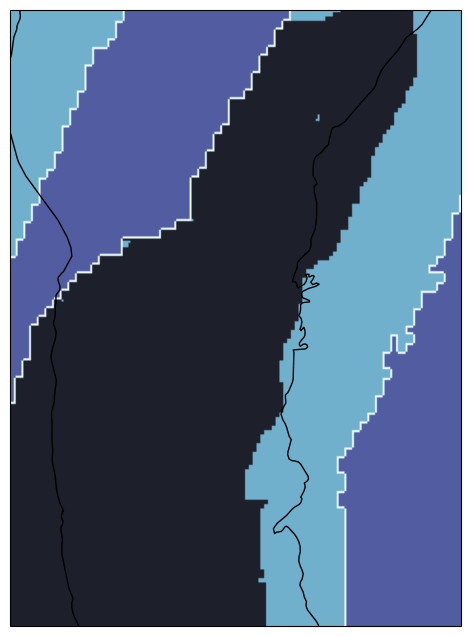

In [48]:
import cmocean as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Создаем фигуру и оси с правильной проекцией
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Увеличиваем фактор прореживания
factor = 5  # Увеличиваем для уменьшения использования памяти

# Прореживание данных
#x_sub = ds_masie_cut['x'].values
#y_sub = ds_masie_cut['y'].values
data_sub = ds_masie_cut_proj.values #['sea_ice_extent'].values

# Оптимизированное построение карты
'''mesh = ax.pcolormesh(
    x_sub,
    y_sub, 
    data_sub[0,:,:], 
    cmap=cm.cm.ice,
    transform=ccrs.NorthPolarStereo(central_longitude=-45),
    shading='auto',  # Автоматическая оптимизация сетки
    rasterized=True,   # Растеризация для экономии памяти
    #extent=[sar_proj.x.min().item(), sar_proj.x.max().item(), sar_proj.y.min().item(), sar_proj.y.max().item()],
)'''
plt.imshow(
    data_sub[0, :, :],
    extent=[sar_proj.x.min().item(), sar_proj.x.max().item(), sar_proj.y.min().item(), sar_proj.y.max().item()],
    cmap=cm.cm.ice,
    origin='upper',
    zorder=1,
    alpha=0.9,
    transform=ccrs.NorthPolarStereo(central_longitude=-45)
)

#ax.set_extent([sar_proj.x.min().item(), sar_proj.x.max().item(), sar_proj.y.min().item(), sar_proj.y.max().item()], crs=ccrs.NorthPolarStereo(central_longitude=-45))

# Добавляем береговую линию
ax.coastlines()

# Оптимизированный цветовой бар
#plt.colorbar(mesh, label='Sea Ice Extent', shrink=0.7)

plt.show()

In [59]:
x_sub.shape 

(236,)

In [60]:
y_sub.shape

(283,)

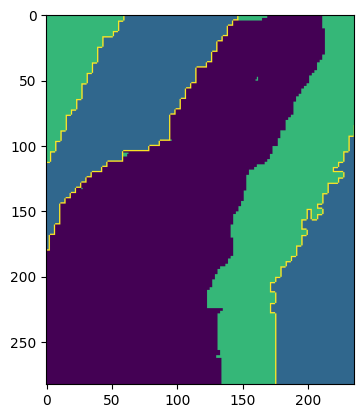

In [61]:
plt.imshow(data_sub[0, :, :])